<a href="https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e21-eda-fss?scriptVersionId=140629853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-21] 📊EDA + FSS📈**

**22 Aug 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Improve a Fixed Model the Data-Centric Way![EN/CN]</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 21</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Overview</center>

⚪ **An interesting task! Different from the usual prediction tasks, this task requires us to perform good feature preprocessing to get the best input data set.**

🔴 一个有趣的任务！不同与往常的预测任务，这次的任务需要我们进行良好的数据预处理，以得到最佳的输入数据集。

⚪ **This means that we don't need to pay attention to the selection and tuning of the model, which reduces a lot of workload.**

🔴 这意味着我们不需要关注模型的选择和调参，这减少了很多工作量。


# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Some Insights in Exploration</center>

⚪ **ID is meaningless, NH4_2 is highly collinear with NH4_1. I originally set them to Nan input model, but could not succeed, this is because RandomForestRegressor does not accept missing values, so I set them to 0.**

🔴 ID没有意义，NH4_2与NH4_1高度共线性。我原本将它们设置为Nan输入模型，但是无法成功，这是因为RandomForestRegressor不接受缺失值，因此我将它们设置为0。

⚪ **Winsorizing outliers does not improve significantly.**

🔴 对异常值进行Winsorize处理没有显著提高。

⚪ **Applying the Yeo-Johnson transformation to features with high slope does not improve significantly.**

🔴 对倾斜度较高的特征进行Yeo-Johnson 变换没有显著提高。

⚪ **I've run out of commits so I don't have a way to keep track of my progress in real time, please let me know my notebook score if you can, thanks a lot!**

🔴 我的提交次数已经用完了，因此我没有办法实时了解我的进展，如果可以的话，请告诉我的Notebook得分，非常感谢！。

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>

| Version | Description | LB Score |
|---------|-------------|----------|
| Version 3 | Set ID and NH4_2 to 0 | should be much better |
| Version 2 | Drop Winsorize | 35 **(WTF is that)** |
| Version 1 | EDA and Baseline |0.79226 |

<a id="0"></a>
# <b> 0. Imports </b>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import math
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

<a id="1"></a>
# <b> 1. Load data </b>

⚪ **Since id is not helpful in modeling, I set it to Nan.**

🔴 鉴于id在建模中毫无帮助，我将它设置为Nan。

In [3]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

submission['id'] = 0
submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,0,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,0,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,0,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,0,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


⚪ **All variables are continuous variables, which means that we can check the correlation coefficient of input variables and target to observe their linear relationship.**

🔴 可以注意到，所有变量均为连续变量，这意味着我们可以检查输入变量与target的相关系数来观察他们的线性关系。

<a id="2"></a>
# <b> 2. Basic EDA </b>

In [4]:
submission.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
id,3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
target,3500.000000,8.473834,1.885712,1.300000,7.470000,8.280000,9.110000,65.930000
O2_1,3500.000000,8.216993,3.040743,0.000000,7.100000,7.890000,9.100000,46.950000
O2_2,3500.000000,9.291581,6.817822,0.000000,7.300000,8.300000,8.700000,65.950000
O2_3,3500.000000,9.633064,1.439039,4.900000,8.770000,9.500000,9.545000,16.900000
O2_4,3500.000000,8.065733,1.463881,2.300000,6.830000,7.980000,9.265000,21.800000
O2_5,3500.000000,5.671581,2.721399,0.200000,4.550000,5.800000,7.015000,59.400000
O2_6,3500.000000,9.461363,1.140365,0.000000,8.980000,9.430000,10.070000,40.190000
O2_7,3500.000000,6.547433,1.663266,0.000000,5.877500,6.430000,7.150000,15.900000
NH4_1,3500.000000,0.340525,0.284751,0.020000,0.214500,0.247000,0.370000,4.200000


In [5]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(submission).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
id,int64,0,0.000000,1,3500,0.000000,0.000000,0.000000,0.000000
target,float64,0,0.000000,462,3500,10.460854,1.300000,65.930000,8.473834
O2_1,float64,0,0.000000,329,3500,7.753354,0.000000,46.950000,8.216993
O2_2,float64,0,0.000000,258,3500,4.314217,0.000000,65.950000,9.291581
O2_3,float64,0,0.000000,235,3500,1.254857,4.900000,16.900000,9.633064
O2_4,float64,0,0.000000,241,3500,0.782568,2.300000,21.800000,8.065733
O2_5,float64,0,0.000000,317,3500,3.740421,0.200000,59.400000,5.671581
O2_6,float64,0,0.000000,238,3500,5.246618,0.000000,40.190000,9.461363
O2_7,float64,0,0.000000,303,3500,0.285303,0.000000,15.900000,6.547433
NH4_1,float64,0,0.000000,152,3500,3.237432,0.020000,4.200000,0.340525


⚪ **There are no missing values in the data.**

🔴 数据中没有缺失值。

⚪ **The data needs to be normalized.**

🔴 数据可能需要归一化。

⚪ **The skewness of some features is too high, which is also the part that needs to be dealt with.**

🔴 一些数据的偏度过高，这也是需要处理的部分。

In [6]:
target = 'target'
num_var = submission.columns.drop(['target','id'])

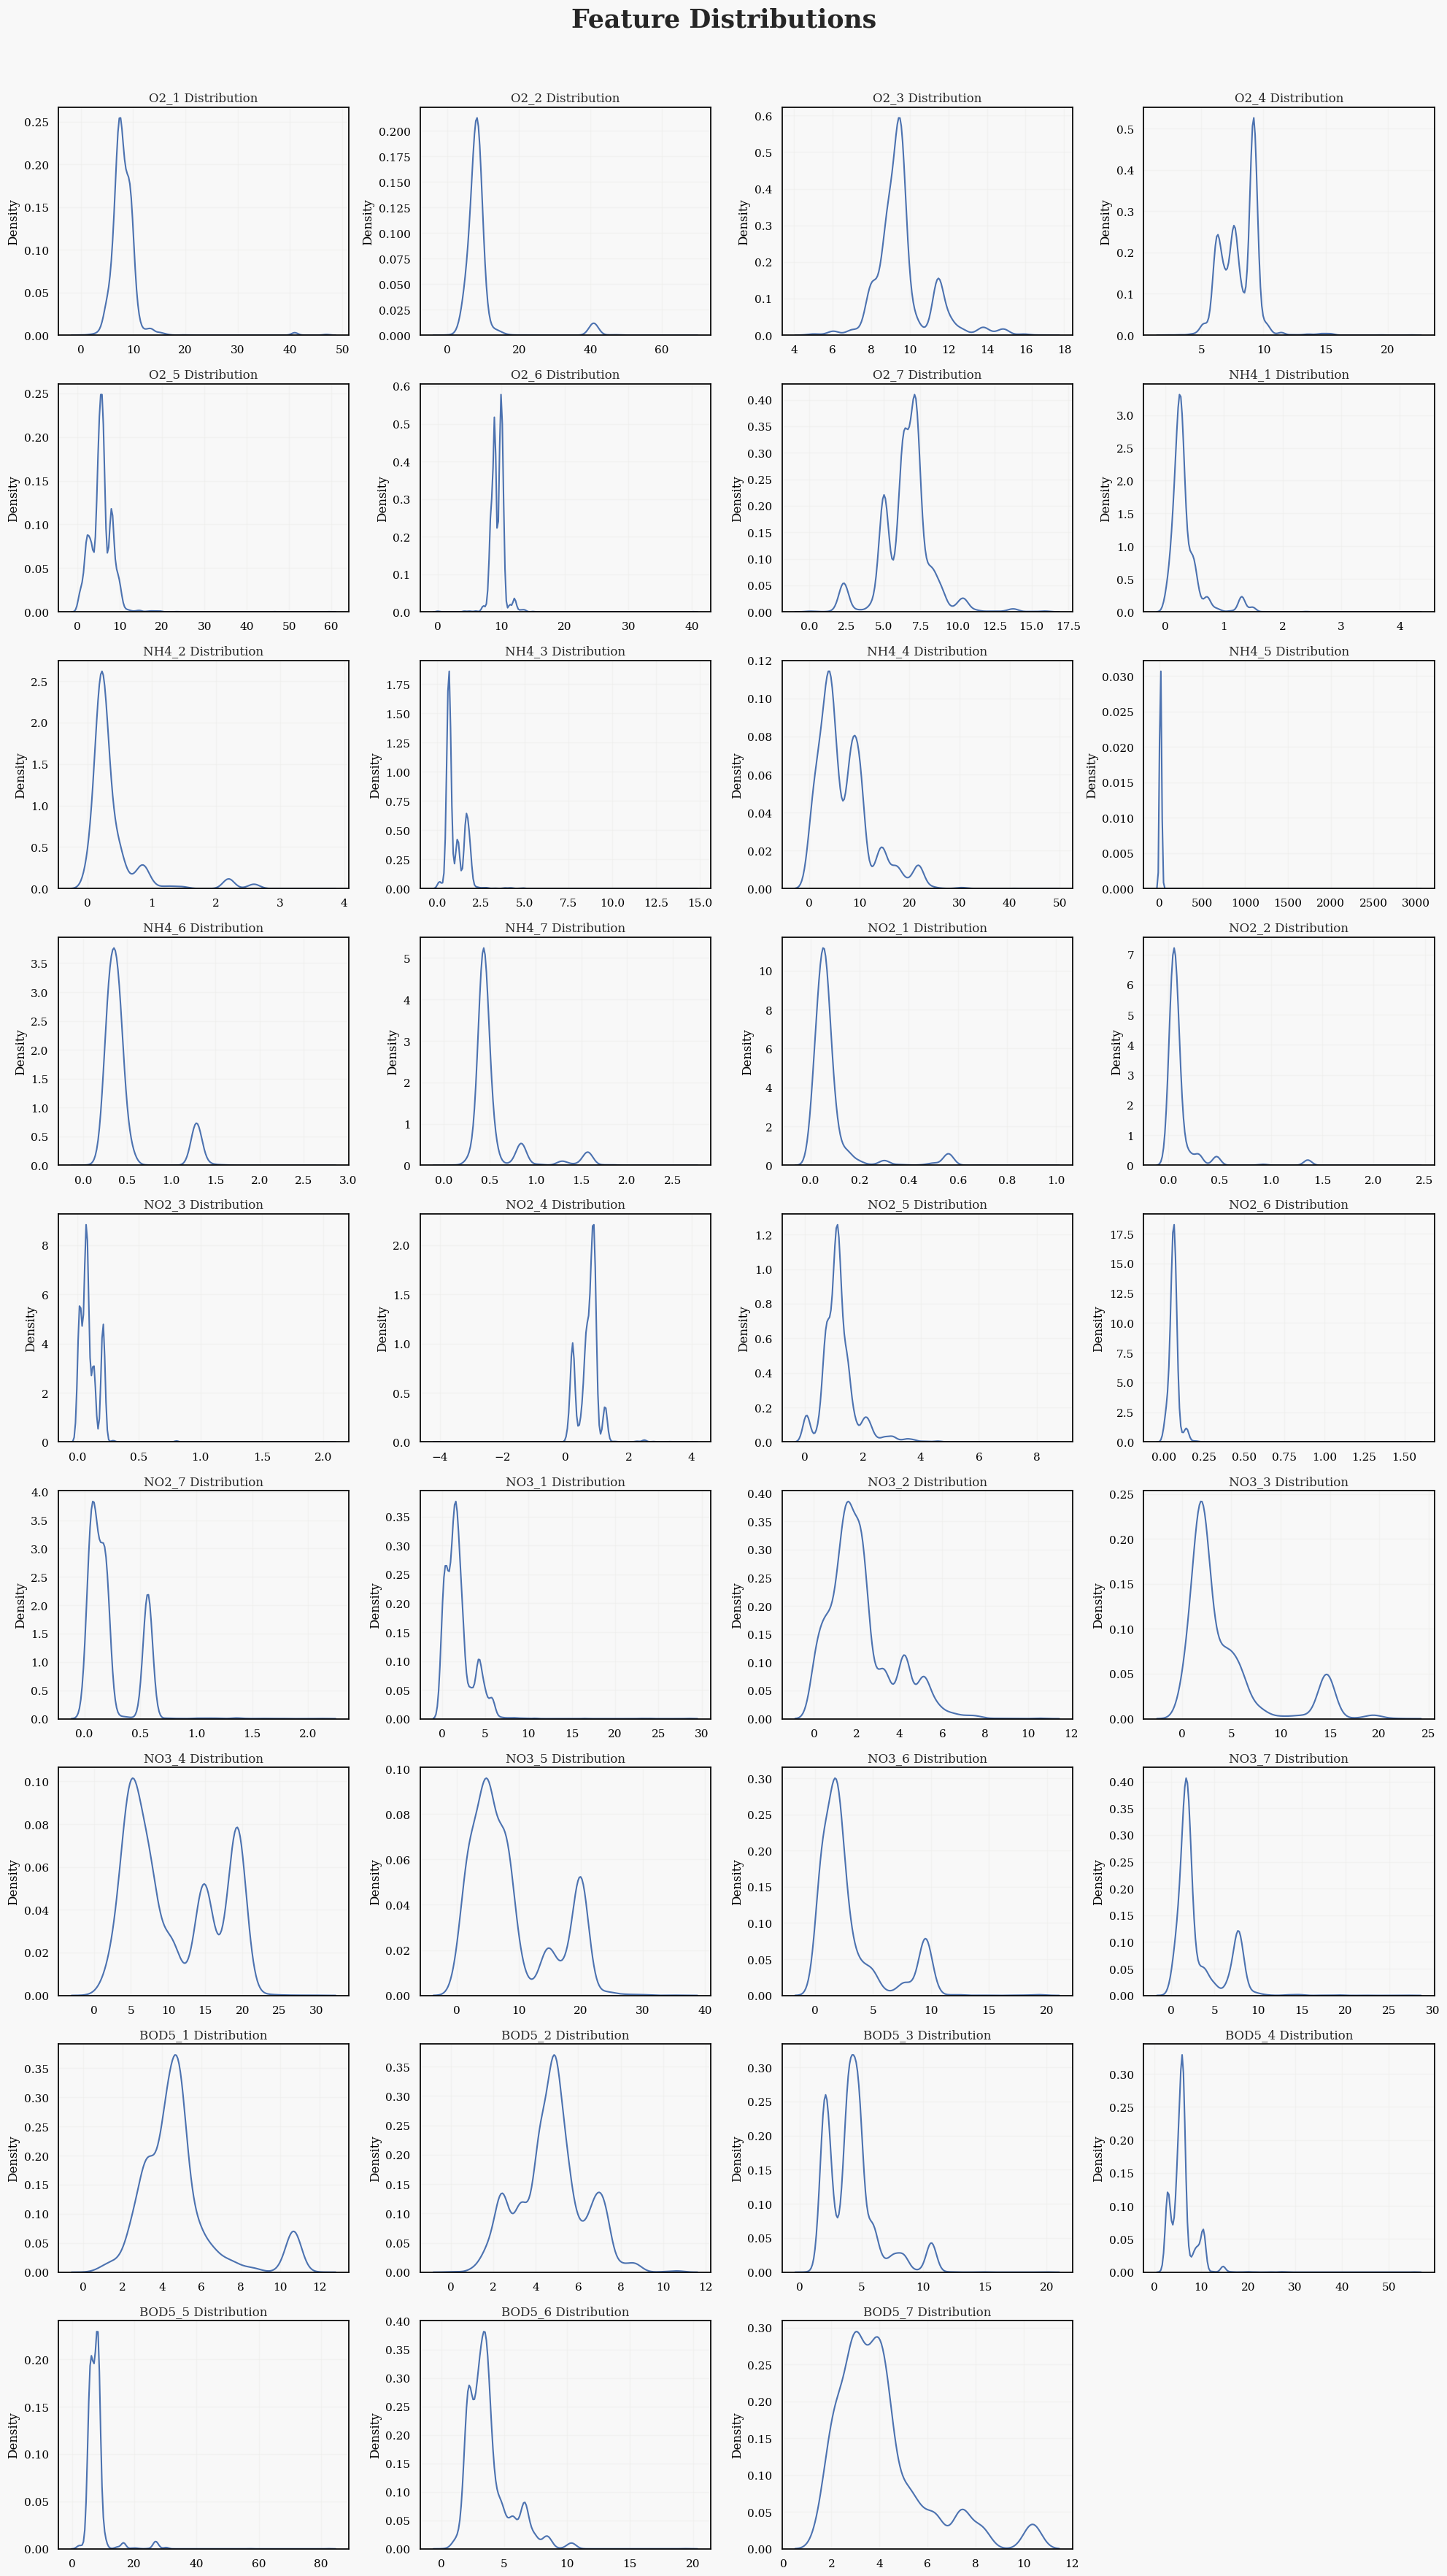

In [7]:
columns = num_var
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    sns.kdeplot(submission[column], ax=ax[i])
    
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
plt.tight_layout()


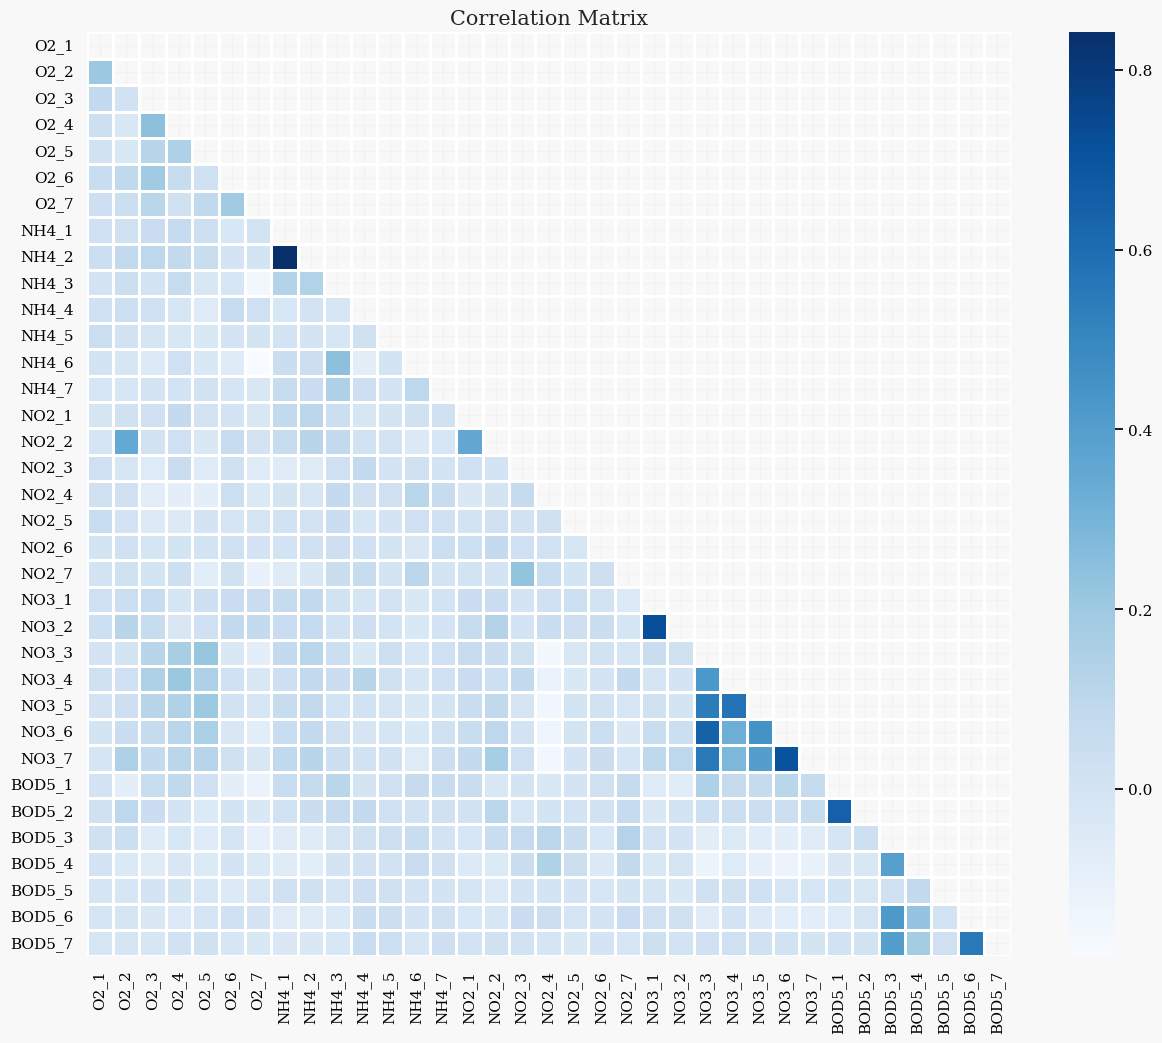

In [8]:
corr_matrix = submission[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

⚪ **Collinearity appeared from NO3_4 to NO3_7.**

🔴 NO3_4至NO3_7出现了共线性。

⚪ **NH4_2 and NH4_1 are highly correlated, I might consider removing one of the columns**

🔴 NH4_2和NH4_1的相关性极高，我可能会考虑去除其中一列。

In [9]:
submission['NH4_2'] = 0

<a id="3"></a>
# <b> 3. Baseline Model</b>

In [10]:
X = submission[num_var]
Y = submission[target]

In [11]:
X

,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,0,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,0,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,0,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,0,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,0,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,0,3.960,2.400,5.550,0.429,0.440,0.059,0.052,0.120,0.950,0.744,0.067,0.037,1.235,0.210,2.025,7.650,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,0,1.640,4.140,12.175,1.285,1.570,0.020,0.020,0.026,0.660,0.746,0.037,0.090,1.700,1.620,2.020,4.900,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,0,1.848,1.800,7.625,0.310,0.844,0.037,0.033,0.026,0.805,1.230,0.056,0.056,2.103,1.620,2.020,19.355,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,0,1.160,8.625,12.175,1.285,0.429,0.560,0.470,0.208,0.660,1.180,0.140,0.190,1.040,0.550,14.670,19.355,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


In [12]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

def evaluation(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test) 
    mse = mean_squared_error(y_test, y_hat)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

In [13]:
# baseline evaluation

evaluation(X,Y)

Root Mean Squared Error: 1.1468632537889791


<a id="4"></a>
# <b> 4. Data Preprocessing</b>

⚪ **For the handling of outliers, I will use the winsorize method. It replaces values above a threshold with that threshold (usually upper and lower quantiles).**

🔴 对于异常值的处理，我将使用winsorize方法。它会将超过阈值的值替换为该阈值（通常为上下分位数）。

In [14]:
def winsorize_function(col):
    if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std()) > 3
    else:
        criterio1 = abs((col-col.median())/col.mad()) > 8
     
    q1 = col.quantile(0.25)  
    q3 = col.quantile(0.75)

    IQR = q3 - q1
    criterio2 = (col < (q1 - 3*IQR)) | (col > (q3 + 3*IQR))
    
    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.count()
    
    return lower, upper


# for col_name in num_var:
#    col = submission[col_name]
#    lower, upper = winsorize_function(col)
#    submission[col_name] = col.apply(lambda x: max(min(x, col.quantile(0.75) + 3*(col.quantile(0.75) - col.quantile(0.25))), col.quantile(0.25) - 3*(col.quantile(0.75) - col.quantile(0.25))))

In [15]:
# Evaluation after winsorize method

evaluation(X = submission[num_var],Y = submission[target])

Root Mean Squared Error: 1.1468632537889794


⚪ **I encountered a problem: after Winsorize transformation, the rmse becomes larger, so I consider removing outliers directly.**

🔴 遇到了一个问题：进行Winsorize变换后，误差变大了，因此我考虑直接去除异常值。

⚪ **For features that are too skewed, I will use a box cox transformation, which will make them more skewed towards a normal distribution.**

🔴 对于偏度过大的特征，我将使用boxcox变换，这将使得它们更加偏向正态分布。

In [16]:
def boxcox_function(data, col, lambda_threshold=0.15):
    transformed_data = data.copy()
    
    for col_name in col:
        col = data[col_name]
        _, maxlog = stats.boxcox(col)
        
        if abs(maxlog) > lambda_threshold:
            transformed_col = np.log1p(col)
            transformed_data[col_name] = transformed_col
            print(f"Applied Box-Cox transform to column: {col_name}")
        else:
            print(f"Skipping Box-Cox transform for column: {col_name}")
    
    return transformed_data

⚪ **Note: Boxcox cannot be used on negative numbers, so I will use the Yeo-Johnson transform instead. This is an advanced transformation of the former.**

🔴 注意:Box Cox无法使用在复数上，因此我将改用Yeo-Johnson 变换。这是前者的进阶变换。

In [17]:
def yeojohnson_function(data, col):
    transformed_data = data.copy()
    
    for col_name in col:
        col = data[col_name]
        
        transformed_col, _ = stats.yeojohnson(col)
        transformed_data[col_name] = transformed_col  
    return transformed_data

transformed_submission = yeojohnson_function(submission, num_var)

In [18]:
# Evaluation after transformation

evaluation(X = transformed_submission[num_var],Y = transformed_submission[target])

Root Mean Squared Error: 1.679720088958786


In [19]:
def data_preprocessing(df):
    sc = StandardScaler()
    for i in df.drop(['id','target'],axis=1).columns:
        df[i] = sc.fit_transform(df[i].values.reshape(-1,1))
    return df

submission = data_preprocessing(submission)
transformed_submission = data_preprocessing(transformed_submission)

In [20]:
# Evaluation without transformation
evaluation(X = submission[num_var],Y = submission[target])

Root Mean Squared Error: 1.1468467722639268


In [21]:
# Evaluation with data transformation
evaluation(X = transformed_submission[num_var],Y = transformed_submission[target])

Root Mean Squared Error: 1.6797221278915915


<a id="5"></a>
# <b> 5. Submission </b>

In [22]:
# baseline submission

submission.to_csv('submission.csv',index=False)
transformed_submission.to_csv('transformed_submission.csv',index=False)

In [23]:
submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,-0.235829,-0.042774,-0.061205,0.819355,0.896145,-0.904544,0.362332,-0.563820,0.0,-0.647971,1.409650,-0.172476,2.631315,-0.386218,-0.490631,-0.318685,-0.399794,0.016586,-0.181325,-0.119441,1.573404,-0.913697,-0.457739,-0.644936,1.414031,-0.584129,-0.436008,-0.531651,-0.008322,-1.036916,3.047811,1.745500,2.364723,1.188726,3.326378
1,0,9.10,1.748509,4.636808,-0.599836,0.819355,0.126210,0.533798,0.362332,2.692119,0.0,1.362577,0.293754,-0.049312,-0.599924,-0.348082,0.063595,6.293610,-0.399794,0.504445,0.415650,-0.119441,-0.188574,0.237740,1.951476,-0.521345,1.414031,1.761418,2.237113,1.640792,-0.132770,1.419023,-1.072893,-0.298543,-0.567349,-0.475781,-0.970585
2,0,8.21,-1.482413,-0.567943,-0.599836,0.819355,-0.412193,0.533798,0.362332,-1.125794,0.0,-0.647971,1.907730,0.193319,-0.278407,-0.348082,-0.208821,-0.318685,-0.182154,0.504445,1.315051,-0.119441,1.573404,-0.144890,-0.324080,-0.090510,-0.993958,-0.641603,0.007799,0.264358,0.058880,0.126423,0.209900,0.041160,-0.292132,-0.148824,-0.474376
3,0,8.39,0.158868,-0.174799,-0.092481,0.774946,-0.173311,-0.694055,0.073701,-0.212586,0.0,1.164543,-0.607109,-0.122568,3.258272,2.910771,-0.302758,-0.318685,-0.327248,-0.550693,0.866138,-0.198674,-0.777457,-0.263168,-0.457739,-0.538671,-1.150548,-0.040459,-0.319487,-0.557448,0.738365,-0.035152,-0.375359,0.089689,0.223397,-0.505504,1.742731
4,0,8.07,-0.054926,-0.094117,-1.162792,0.819355,-0.875256,0.533798,0.362332,0.068401,0.0,-0.647971,-0.610898,-0.172476,-0.599924,-0.348082,0.213894,0.009406,-0.278883,1.497182,-0.181325,0.078640,-0.188574,-0.529293,-0.691644,-0.521345,-1.160210,-1.039259,-0.436008,-0.914915,-0.008322,0.139349,-0.160366,-1.230300,0.150901,-0.148824,-0.089021


In [24]:
transformed_submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,-0.199634,0.350425,0.046461,0.848356,0.964453,-0.919531,0.364497,-0.711175,0.0,-0.704386,1.329914,-1.259276,2.028241,-0.357734,-0.942373,-0.459291,-0.327000,0.023952,-0.058480,-0.086534,1.511066,-1.234640,-0.309947,-0.774303,1.281675,-0.403421,-0.169324,-0.359307,0.193686,-1.035816,2.122148,1.643284,2.383601,1.266491,2.143209
1,0,9.10,2.075413,3.188147,-0.568215,0.848356,0.238990,0.555622,0.364497,2.074655,0.0,1.432195,0.537930,-0.008885,-1.079513,-0.239743,0.759667,2.310103,-0.327000,0.509794,0.579235,-0.086534,0.215480,0.540277,1.660984,-0.389981,1.281675,1.477744,1.684798,1.486345,0.052079,1.394060,-1.415180,-0.160988,-0.901636,-0.349022,-1.291092
2,0,8.21,-3.132375,-1.329073,-0.568215,0.848356,-0.343325,0.555622,0.364497,-2.689937,0.0,-0.704386,1.604479,1.287856,0.075310,-0.239743,0.084870,-0.459291,-0.002148,0.509794,1.359679,-0.086534,1.511066,0.122366,-0.144288,0.419161,-1.019064,-0.495182,0.512015,0.733720,0.267005,0.150276,0.469328,0.242070,-0.247258,0.096588,-0.330372
3,0,8.39,0.392624,0.037399,0.012877,0.807491,-0.075576,-0.698985,0.076363,0.049509,0.0,1.310001,-0.482358,-0.654551,2.068091,2.222974,-0.213356,-0.459291,-0.214371,-0.545581,0.992534,-0.350664,-1.027265,-0.030386,-0.309947,-0.437601,-1.297814,0.268538,0.052333,-0.417336,0.907574,-0.010101,-0.195942,0.294883,0.637056,-0.394602,1.562459
4,0,8.07,0.084287,0.234721,-1.305591,0.848356,-0.917126,0.555622,0.364497,0.499677,0.0,-0.704386,-0.488155,-1.259276,-1.079513,-0.239743,1.037859,0.840278,-0.141747,1.488601,-0.058480,0.502916,0.215480,-0.431806,-0.632325,-0.389981,-1.316355,-1.354668,-0.169324,-1.584464,0.193686,0.163053,0.074530,-1.734698,0.532407,0.096588,0.193455


<p style="font-family: consolas; font-size: 16px;">⚪ If you like it, please upvote it!</p>